In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
import torch
# Neural networks can be constructed using the torch.nn package.
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

# Any results you write to the current directory are saved as output.

In [2]:
#!pip install fast_ml

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [4]:
BASE_PATH = './data/bacteria/'

In [5]:
image=[]
labels=[]
for file in os.listdir(BASE_PATH):
    if file=='Lactobacillus.crispatus':
        for c in os.listdir(os.path.join(BASE_PATH, file)):
            if c!='annotations':
                image.append(c)
                labels.append('Lactobacillus.crispatus')
    if file=='Proteus':
        for c in os.listdir(os.path.join(BASE_PATH, file)):
            if c!='annotations':
                image.append(c)
                labels.append('Proteus')

data = {'Images':image, 'labels':labels} 
data = pd.DataFrame(data) 
data.head()
#print(data.labels)

Images                   labels
0  Lactobacillus.crispatus_0001_03.png  Lactobacillus.crispatus
1  Lactobacillus.crispatus_0001_08.png  Lactobacillus.crispatus
2  Lactobacillus.crispatus_0001_09.png  Lactobacillus.crispatus
3  Lactobacillus.crispatus_0001_10.png  Lactobacillus.crispatus
4  Lactobacillus.crispatus_0001_13.png  Lactobacillus.crispatus

In [6]:
lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])
data.head()

Images                   labels  \
0  Lactobacillus.crispatus_0001_03.png  Lactobacillus.crispatus   
1  Lactobacillus.crispatus_0001_08.png  Lactobacillus.crispatus   
2  Lactobacillus.crispatus_0001_09.png  Lactobacillus.crispatus   
3  Lactobacillus.crispatus_0001_10.png  Lactobacillus.crispatus   
4  Lactobacillus.crispatus_0001_13.png  Lactobacillus.crispatus   

   encoded_labels  
0               0  
1               0  
2               0  
3               0  
4               0

### Spliting of Dataset
I have shown two ways to split a dataset into train and validation. One is by splitting it from sratch and another method is by using train_test_split from scikit-learn( the one which I have commented out).

In [7]:
batch_size = 128
validation_split = .1
test_split = .1
shuffle_dataset = True
random_seed= 42

In [8]:
X = data.drop(columns = ['labels']).copy()
y = data['labels']

from fast_ml.model_development import train_valid_test_split
x_train, y_train, x_valid, y_valid, x_test, y_test = train_valid_test_split(data, target = 'labels', train_size=0.8, valid_size=0.1, test_size=0.1)

print(x_train.shape), print(y_train.shape)
print(x_valid.shape), print(y_valid.shape)
print(x_test.shape), print(y_test.shape)
train_indices, val_indices, test_indices= list(x_train.index), list(x_valid.index), list(x_test.index)
#print(x_train.index)
#print(train_indices)
#print(val_indices)

(1219, 2)
(1219,)
(152, 2)
(152,)
(153, 2)
(153,)


In [9]:
# Creating data indices for training and validation splits:
#from sklearn.model_selection import train_test_split
#tr, val = train_test_split(data.labels, stratify=data.label, test_size=0.1)

# dataset_size = len(data)
# indices = list(range(dataset_size))
# split = int(np.floor(validation_split * dataset_size))
# if shuffle_dataset :
#     np.random.seed(random_seed)
#     np.random.shuffle(indices)
    
# train_indices, val_indices = indices[split:], indices[:split]

# print(train_indices)
# print(val_indices)

#train_indices is equivalent to list(tr.index)
#val_indices is equivalent to list(val.index)

In [10]:
# Creating PT data samplers and loaders:

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

### Transforms
Transforms are common image transformations. They can be chained together using Compose.

### Normalization
Normalize a tensor image with mean and standard deviation. Given mean: (M1,...,Mn) and std: (S1,..,Sn) for n channels, this transform will normalize each channel of the input torch.*Tensor i.e. input[channel] = (input[channel] - mean[channel]) / std[channel] Convert a PIL Image or numpy.ndarray to tensor.

### ToTensor
Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1) or if the numpy.ndarray has dtype = np.uint8

In [11]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

### Create custom dataset class
A dataset must contain following functions to be used by data loader later on.

init() function is where the initial logic happens like reading a csv, assigning transforms etc.

getitem() function returns the data and labels. This function is called from dataloader like this:Create custom dataset class
A dataset must contain following functions to be used by data loader later on.


In [12]:
class Bacteria_Dataset(Dataset):
    def __init__(self, img_data,img_path,transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_path,self.img_data.loc[index, 'labels'],
                                self.img_data.loc[index, 'Images'])
        image = Image.open(img_name)
        #image = image.convert('RGB')
        image = image.resize((300,300))
        label = torch.tensor(self.img_data.loc[index, 'encoded_labels'])
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [13]:
dataset = Bacteria_Dataset(data,BASE_PATH,transform)

In [14]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=test_sampler)

In [15]:
def img_display(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

### Visualization
visualizing the elements of the dataset

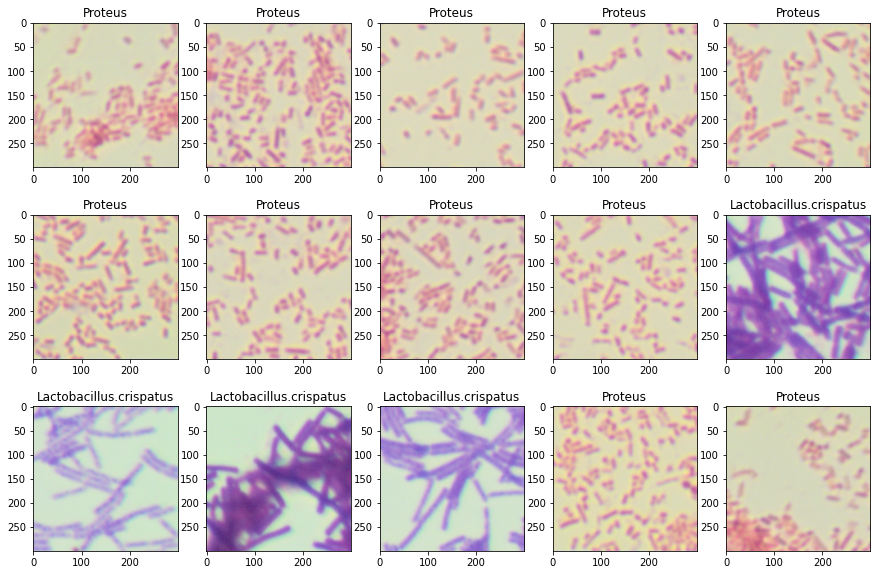

In [16]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
arthopod_types = {0: 'Lactobacillus.crispatus', 1: 'Proteus'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(img_display(image)) # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

### The Neural Network
In the Net class created below, we have constructed a neural network. Construction of the neural network was the second most difficult situation that I faced after constructing a custom dataset. But I am going to explain you everything step by step.

Inside the init() method you declare each layer with a unique layer name. For every unique layer, declaring its input features and output features is a must. At least the input feature is a must for some of the layers like batch normalization.

Inside the forward(self, x) method you need to connect the layers that were declared in the init method. One thing must be kept in mind that the output feature of one layer is an input feature of its next connecting layer.

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 3 input image channel, 16 output channels, 3x3 square convolution kernel
        self.conv1 = nn.Conv2d(3,16,kernel_size=3,stride=2,padding=1)
        self.conv2 = nn.Conv2d(16, 32,kernel_size=3,stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64,kernel_size=3,stride=2, padding=1)
        self.conv4 = nn.Conv2d(64, 64,kernel_size=3,stride=2, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout2d(0.4)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64*5*5,512 )
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 4)
        
    def forward(self, x):
        x = self.batchnorm1(F.relu(self.conv1(x)))
        x = self.batchnorm2(F.relu(self.conv2(x)))
        x = self.dropout(self.batchnorm2(self.pool(x)))
        x = self.batchnorm3(self.pool(F.relu(self.conv3(x))))
        x = self.dropout(self.conv4(x))
        x = x.view(-1, 64*5*5) # Flatten layer
        x = self.dropout(self.fc1(x))
        x = self.dropout(self.fc2(x))
        x = F.log_softmax(self.fc3(x),dim = 1)
        return x

In [18]:
#model = Net() # On CPU
model = Net().to(device)  # On GPU
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.4, inplace=False)
  (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1600, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=4, bias=True)
)


### CrossEntropyLoss
It is useful when training a classification problem with C classes. If provided, the optional argument weight should be a 1D Tensor assigning weight to each of the classes. This is particularly useful when you have an unbalanced training set. It is a prototpe of categorical crossentropy in keras. In case of Binary classification use BCELoss(Binary Cross Entropy) or BCEWithLogitsLoss.

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [20]:
def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

### Training the Network
In the cell below, it is explained how to train your model with epochs. In the "train_loss" and "val_loss" the training loss and validation loss are stored respectively after every epoch. Similarly in case of training accuracy and validation accuracy also, the same thing happens. just remember while validation the weighhts are not upgraded thats why we use " with torch.no_grad() ".

Here, "Torch.max(x, dim=1)" works same as "np.argmax(x, axis=1)". We use ".item()" to get the value inside the tensor. torch.save(model.state_dict(), 'model_classification_tutorial.pt') is used to save the PyTorch weight in the given directory.

In [21]:
n_epochs = 10
print_every = 2
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_loader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    # scheduler.step(epoch)
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_loader):
        data_, target_ = data_.to(device), target_.to(device)# on GPU
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(data_)
        target_ = target_.long()
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain loss: {np.mean(train_loss):.4f}, train acc: {(100 * correct / total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        model.eval()
        for data_t, target_t in (validation_loader):
            data_t, target_t = data_t.to(device), target_t.to(device)# on GPU
            outputs_t = model(data_t)
            target_t = target_t.long()
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t / total_t)
        val_loss.append(batch_loss/len(validation_loader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t / total_t):.4f}\n')
        # Saving the best weight 
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(model.state_dict(), 'model_classification_tutorial.pt')
            print('Detected network improvement, saving current model')
    model.train()

Epoch 1

Epoch [1/10], Step [0/10], Loss: 1.4269

train loss: 0.9476, train acc: 78.5890
validation loss: 1.2131, validation acc: 60.5263

Detected network improvement, saving current model
Epoch 2

Epoch [2/10], Step [0/10], Loss: 0.3589

train loss: 0.5409, train acc: 100.0000
validation loss: 1.4605, validation acc: 60.5263

Epoch 3

Epoch [3/10], Step [0/10], Loss: 0.0217

train loss: 0.3629, train acc: 100.0000
validation loss: 1.6063, validation acc: 60.5263

Epoch 4

Epoch [4/10], Step [0/10], Loss: 0.0015

train loss: 0.2725, train acc: 100.0000
validation loss: 1.5454, validation acc: 60.5263

Epoch 5

Epoch [5/10], Step [0/10], Loss: 0.0003

train loss: 0.2180, train acc: 100.0000
validation loss: 1.3521, validation acc: 76.9737

Detected network improvement, saving current model
Epoch 6

Epoch [6/10], Step [0/10], Loss: 0.0020

train loss: 0.1818, train acc: 100.0000
validation loss: 1.1736, validation acc: 90.1316

Detected network improvement, saving current model
Epoch 7


### Accuracy and loss Curve

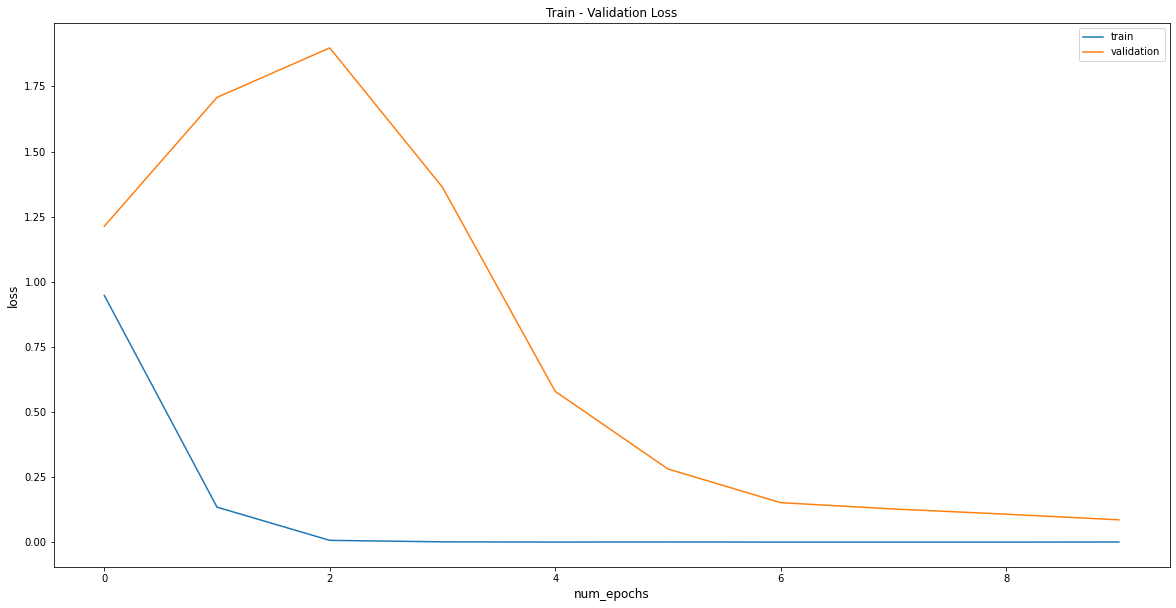

In [22]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Loss")
plt.plot( train_loss, label='train')
plt.plot( val_loss, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')

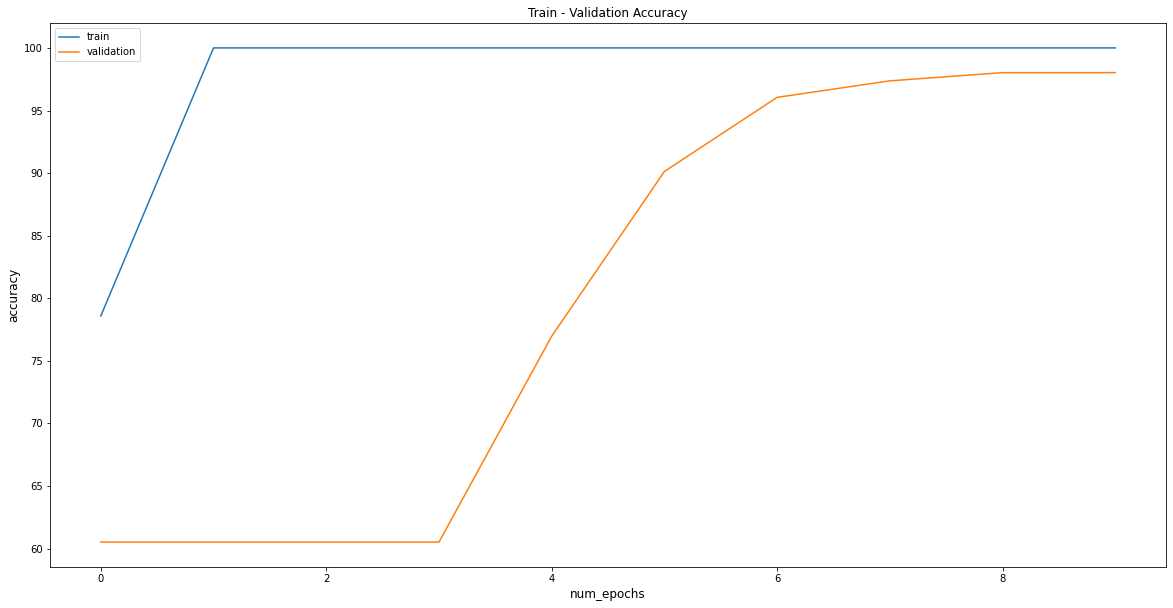

In [23]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

In [24]:
# Importing trained Network with better loss of validation
model.load_state_dict(torch.load('model_classification_tutorial.pt'))

<All keys matched successfully>

### Evaluation
evaluating the model performance through visualization

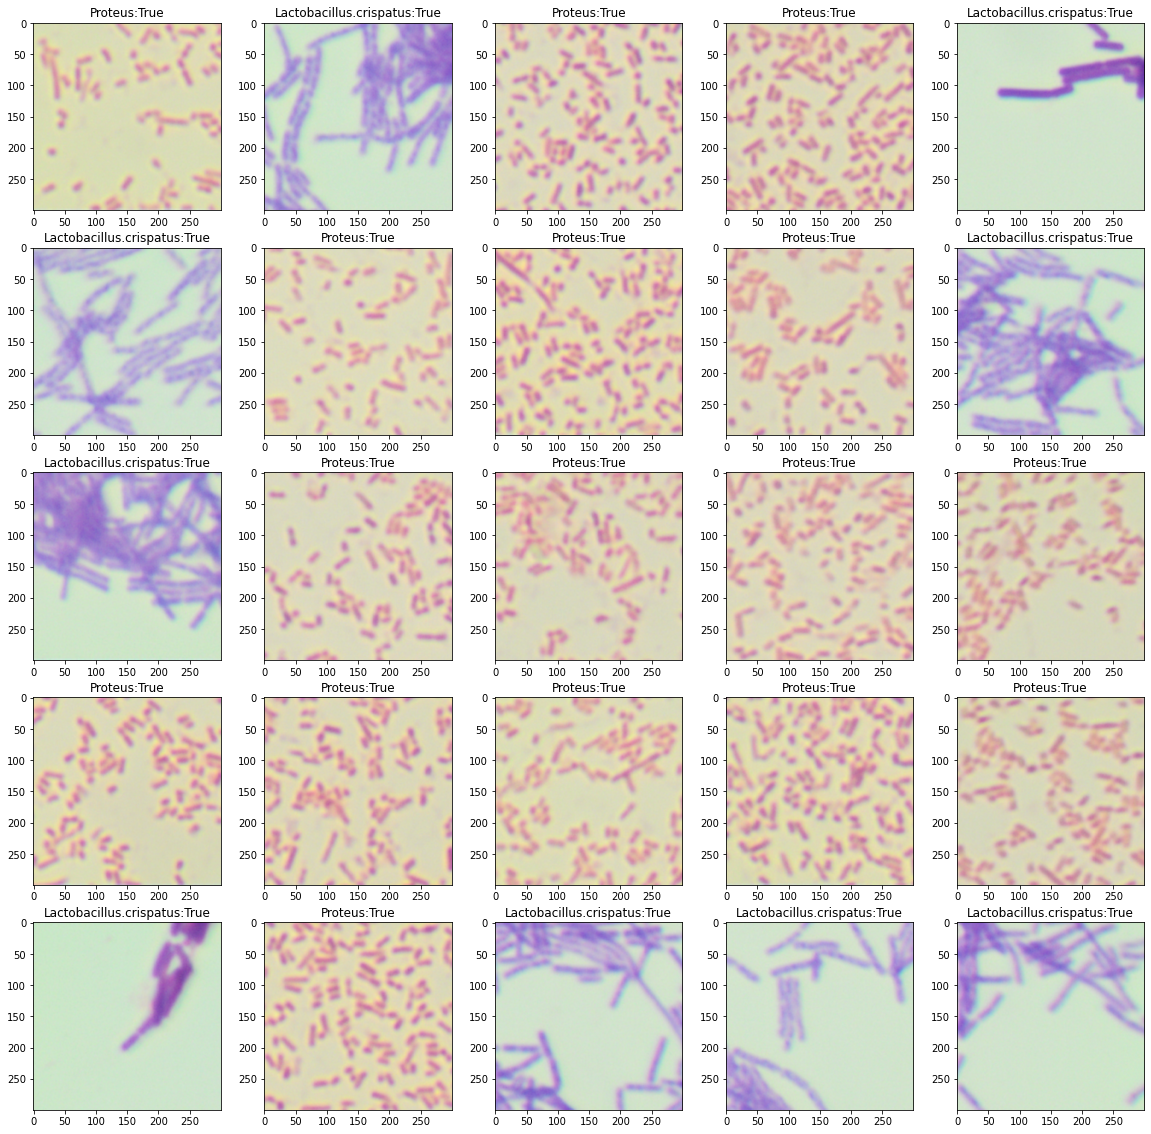

In [25]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
arthopod_types = {0: 'Lactobacillus.crispatus', 1: 'Proteus'}
# Viewing data examples used for training
fig, axis = plt.subplots(5, 5, figsize=(20, 20))
with torch.no_grad():
    model.eval()
    for ax, image, label in zip(axis.flat,images, labels):
        ax.imshow(img_display(image)) # add image
        image_tensor = image.unsqueeze_(0).cuda()
        output_ = model(image_tensor)
        output_ = output_.argmax()
        k = output_.item()==label.item()
        ax.set_title(str(arthopod_types[label.item()])+":" +str(k)) # add label

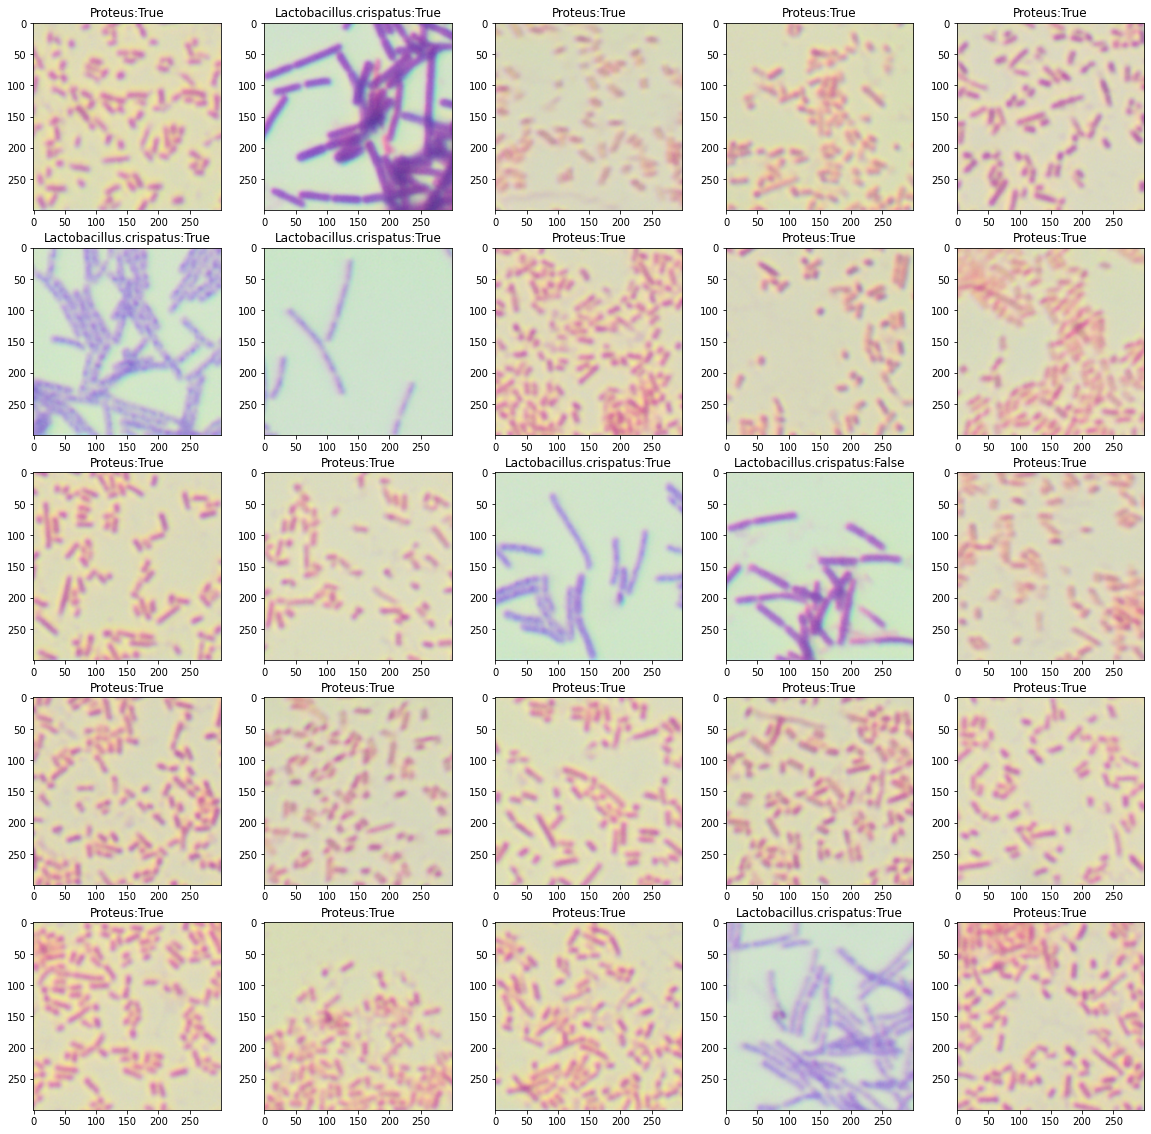

In [26]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
arthopod_types = {0: 'Lactobacillus.crispatus', 1: 'Proteus'}
# Viewing data examples used for training
fig, axis = plt.subplots(5, 5, figsize=(20, 20))
with torch.no_grad():
    model.eval()
    for ax, image, label in zip(axis.flat,images, labels):
        ax.imshow(img_display(image)) # add image
        image_tensor = image.unsqueeze_(0).cuda()
        output_ = model(image_tensor)
        output_ = output_.argmax()
        k = output_.item()==label.item()
        ax.set_title(str(arthopod_types[label.item()])+":" +str(k)) # add label
        

In [27]:
len(test_sampler)

153

In [28]:
total_t=0
correct_t=0
test_acc = []
with torch.no_grad():
    model.eval()
    for data_t, target_t in (test_loader):
        data_t, target_t = data_t.to(device), target_t.to(device)# on GPU
        outputs_t = model(data_t)
        target_t = target_t.long()
        _,pred_t = torch.max(outputs_t, dim=1)
        print(pred_t)
        print(target_t)
        correct_t += torch.sum(pred_t==target_t).item()
        total_t += target_t.size(0)
    test_acc.append(100 * correct_t / total_t)
    print(f'validation acc: {(100 * correct_t / total_t):.4f}\n')

tensor([0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,
        0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
        0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1,
        0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
        1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        0, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
tensor([0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,
        0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
        0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1,
        0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
        1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        0, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
tensor([1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1,
        1], device='